In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hierarchical-validate/all_sequences.fasta
/kaggle/input/virus_final/scikitlearn/default/1/virus.pkl
/kaggle/input/tfidf_gene/scikitlearn/default/1/tfidf .pkl
/kaggle/input/bacteria_final/scikitlearn/default/1/bacteria .pkl
/kaggle/input/level_1_model/scikitlearn/default/1/level_1.pkl


In [2]:
!pip install --upgrade pip numpy scikit-learn pandas keras tensorflow torch dill matplotlib seaborn lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 46.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 76.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.8 MB/s eta 0:00:00:00:01m00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 68.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 10.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [3]:
pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 72.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
import dill

In [5]:
from collections import Counter

def gc_content(sequence):
    g_count = sequence.count('G')
    c_count = sequence.count('C')
    total_bases = len(sequence)
    gc_percentage = (g_count + c_count) / total_bases * 100
    return gc_percentage

def at_content(sequence):
    a_count = sequence.count('A')
    t_count = sequence.count('T')
    total_bases = len(sequence)
    at_percentage = (a_count + t_count) / total_bases * 100
    return at_percentage

def kmer_frequencies(sequence, k=3):
    kmers = [sequence[i:i+k] for i in range(len(sequence) - k + 1)]
    kmer_counts = Counter(kmers)
    return kmer_counts

def molecular_weight(sequence):
    nucleotide_weights = {
        'A': 331.2,
        'T': 322.2,
        'C': 307.2,
        'G': 347.2
    }
    weight = sum(nucleotide_weights[nuc] for nuc in sequence if nuc in nucleotide_weights)
    return weight

def hydrophobicity(sequence):
    hydrophobic_nucleotides = {'A', 'T'}
    hydrophilic_nucleotides = {'C', 'G'}
    hydrophobic_score = sum(1 for nuc in sequence if nuc in hydrophobic_nucleotides)
    hydrophilic_score = sum(1 for nuc in sequence if nuc in hydrophilic_nucleotides)
    return hydrophobic_score / len(sequence), hydrophilic_score / len(sequence)

def dinucleotide_frequencies(seq):
    dinucs = [seq[i:i+2] for i in range(len(seq)-1)]
    freq = Counter(dinucs)
    return {dinuc: freq[dinuc] / len(dinucs) for dinuc in freq}

def sequence_entropy(seq):
    freq = Counter(seq)
    probs = [freq[base] / len(seq) for base in freq]
    return -sum(p * np.log2(p) for p in probs)


def Kmers_contribution(seq, size=6):
    return [seq[x:x+size].lower() for x in range(len(seq) - size + 1)]

In [20]:
plasmid_lvl1 =[]
with open("/kaggle/input/viral-and-nonviral-gene/plasmid.fasta","r") as fasta_file:
    for seq_record in SeqIO.parse(fasta_file,"fasta"):
        plasmid_lvl1.append(str(seq_record.seq))
print(len(plasmid_lvl1))
zika_virus = []
with open("/kaggle/input/viral-and-nonviral-gene/viral_gene2/Zika_virus.fasta", "r") as fasta_file:
    for seq_record in SeqIO.parse(fasta_file, "fasta"):
        zika_virus.append(str(seq_record.seq))
chikungunya_virus = []
with open("/kaggle/input/viral-and-nonviral-gene/viral_gene2/Chikungunya_virus.fasta","r") as fasta_file:
    for seq_record in SeqIO.parse(fasta_file,"fasta"):
        chikungunya_virus.append(str(seq_record.seq))
herpes_simplex_virus_1 = []
with open("/kaggle/input/viral-and-nonviral-gene/viral_gene2/Herpes_simplex_virus_1.fasta","r") as fasta_file:
    for seq_record in SeqIO.parse(fasta_file,"fasta"):
        herpes_simplex_virus_1.append(str(seq_record.seq))
human_mastadenovirus_c = []
with open("/kaggle/input/viral-and-nonviral-gene/viral_gene2/Human_mastadenovirus_C.fasta","r") as fasta_file:
    for seq_record in SeqIO.parse(fasta_file,"fasta"):
        human_mastadenovirus_c.append(str(seq_record.seq))
human_papillomavirus = []
with open("/kaggle/input/viral-and-nonviral-gene/viral_gene2/Human_papillomavirus.fasta","r") as fasta_file:
    for seq_record in SeqIO.parse(fasta_file,"fasta"):
        human_papillomavirus.append(str(seq_record.seq))
influenza_a_virus = []
with open("/kaggle/input/viral-and-nonviral-gene/viral_gene2/Influenza_A_virus.fasta","r") as fasta_file:
    for seq_record in SeqIO.parse(fasta_file,"fasta"):
        influenza_a_virus.append(str(seq_record.seq))
print(len(influenza_a_virus))

3896
1500


In [21]:
bacillus_subtilis = []
with open("/kaggle/input/viral-and-nonviral-gene/viral_gene2/Bacillus_subtilis.fasta","r") as fasta_file:
    for seq_record in SeqIO.parse(fasta_file,"fasta"):
        bacillus_subtilis.append(str(seq_record.seq))
clostridium_botulinum = []
with open("/kaggle/input/viral-and-nonviral-gene/viral_gene2/Clostridium_botulinum.fasta","r") as fasta_file:
    for seq_record in SeqIO.parse(fasta_file,"fasta"):
        clostridium_botulinum.append(str(seq_record.seq))
escherichia_coli = []
with open("/kaggle/input/viral-and-nonviral-gene/viral_gene2/Escherichia_coli.fasta","r") as fasta_file:
    for seq_record in SeqIO.parse(fasta_file,"fasta"):
        escherichia_coli.append(str(seq_record.seq))
pseudomonas_aeruginosa = []
with open("/kaggle/input/viral-and-nonviral-gene/viral_gene2/Pseudomonas_aeruginosa.fasta","r") as fasta_file:
    for seq_record in SeqIO.parse(fasta_file,"fasta"):
        pseudomonas_aeruginosa.append(str(seq_record.seq))
staphylococcus_aureus = []
with open("/kaggle/input/viral-and-nonviral-gene/viral_gene2/Staphylococcus_aureus.fasta","r") as fasta_file:
    for seq_record in SeqIO.parse(fasta_file,"fasta"):
        staphylococcus_aureus.append(str(seq_record.seq))
listeria_monocytogenes = []
with open("/kaggle/input/viral-and-nonviral-gene/viral_gene2/Listeria_monocytogenes.fasta","r") as fasta_file:
    for seq_record in SeqIO.parse(fasta_file,"fasta"):
        listeria_monocytogenes.append(str(seq_record.seq))

print(len(listeria_monocytogenes))

1500


In [22]:
import random

all_sequences = {
    "escherichia_coli": escherichia_coli,
    "bacillus_subtilis": bacillus_subtilis,
    "pseudomonas_aeruginosa": pseudomonas_aeruginosa,
    "staphylococcus_aureus": staphylococcus_aureus,
    "listeria_monocytogenes": listeria_monocytogenes,
    "clostridium_botulinum": clostridium_botulinum,
    "zika_virus": zika_virus,
    "influenza_a_virus": influenza_a_virus,
    "chikungunya_virus": chikungunya_virus,
    "human_mastadenovirus_c": human_mastadenovirus_c,
    "human_papillomavirus": human_papillomavirus,
    "herpes_simplex_virus_1": herpes_simplex_virus_1,
    "plasmid": plasmid_lvl1,
}

validation_sequences = {}

for organism, sequences in all_sequences.items():
    if organism == "plasmid":
        validation_sequences[organism] = random.sample(sequences, 600) if len(sequences) >= 600 else sequences
    else:
        validation_sequences[organism] = random.sample(sequences, 100) if len(sequences) >= 100 else sequences


In [23]:
len(validation_sequences["plasmid"])

600

In [24]:
df = pd.DataFrame(columns=['Sequence', 'GC', 'AT', 'Molecular Wt', 'Hydrophobic Score', 'Hydrophilic Score', 'Sequence Entropy', 'Organism'])

In [25]:
for name, sequences in validation_sequences.items():
    for seq in sequences:
        seq = seq.replace('\n', '')
        words = Kmers_contribution(seq)
        joined_words = ' '.join(words)
        gc = gc_content(seq)
        at = at_content(seq)
        mw = molecular_weight(seq)
        hydrophobic_score, hydrophilic_score = hydrophobicity(seq)
        s_entropy = sequence_entropy(seq)
        
        df.loc[len(df)] = [joined_words, gc, at, mw, hydrophobic_score, hydrophilic_score, s_entropy, name]

print(df.shape)

(1800, 8)


In [26]:
df.sample(10)

,Sequence,GC,AT,Molecular Wt,Hydrophobic Score,Hydrophilic Score,Sequence Entropy,Organism
1541,ggcagt gcagtt cagttg agttga gttgac ttgaca tgac...,53.299504,46.700496,1.392013e+07,0.467005,0.532995,1.996848,plasmid
1749,atgagc tgagcg gagcgc agcgcc gcgccg cgccgc gccg...,47.451942,52.548058,2.537537e+06,0.525481,0.474519,1.994884,plasmid
361,atataa tataaa ataaat taaata aaataa aataac ataa...,30.441832,69.558168,8.109424e+05,0.695582,0.304418,1.858962,staphylococcus_aureus
244,acgggc cgggcg gggcgc ggcgct gcgctg cgctgg gctg...,57.084826,42.912771,1.358020e+07,0.429128,0.570848,1.984878,pseudomonas_aeruginosa
954,gactac actacc ctacct tacctt accttt cctttc cttt...,52.760736,47.239264,2.648010e+05,0.472393,0.527607,1.980916,human_mastadenovirus_c
1092,aacatg acatga catgac atgact tgacta gactat acta...,35.310734,64.689266,1.159538e+05,0.646893,0.353107,1.927827,human_papillomavirus
1598,tgtttt gttttt tttttt tttttc ttttca tttcaa ttca...,26.289006,73.710994,1.407908e+07,0.737110,0.262890,1.819227,plasmid
1361,tttcaa ttcaaa tcaaat caaata aaatat aatata atat...,36.276588,63.723412,1.695026e+07,0.637234,0.362766,1.944505,plasmid
216,aacagc acagct cagctc agctcc gctcct ctcctg tcct...,67.215170,32.784830,5.971843e+07,0.327848,0.672152,1.912654,pseudomonas_aeruginosa
426,attcca ttccaa tccaac ccaaca caacaa aacaag acaa...,37.377616,62.622384,9.713576e+07,0.626224,0.373776,1.949662,listeria_monocytogenes


In [27]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Organism'] = le.fit_transform(df['Organism'])

In [28]:
encoding_dict = {class_label: index for index, class_label in enumerate(le.classes_)}
print(encoding_dict)

{'bacillus_subtilis': 0, 'chikungunya_virus': 1, 'clostridium_botulinum': 2, 'escherichia_coli': 3, 'herpes_simplex_virus_1': 4, 'human_mastadenovirus_c': 5, 'human_papillomavirus': 6, 'influenza_a_virus': 7, 'listeria_monocytogenes': 8, 'plasmid': 9, 'pseudomonas_aeruginosa': 10, 'staphylococcus_aureus': 11, 'zika_virus': 12}


In [29]:
import dill
tfidf_path = "/kaggle/input/tfidf_gene/scikitlearn/default/1/tfidf .pkl"
with open(tfidf_path, "rb") as f:
    tfidf = dill.load(f)

lvl1_path = "/kaggle/input/level_1_model/scikitlearn/default/1/level_1.pkl"
with open(lvl1_path, "rb") as f:
    model_lvl1 = dill.load(f)

bacteria_path = "/kaggle/input/bacteria_final/scikitlearn/default/1/bacteria .pkl"
with open(bacteria_path, "rb") as f:
    model_bacteria = dill.load(f)

virus_path = "/kaggle/input/virus_final/scikitlearn/default/1/virus.pkl"
with open(virus_path, "rb") as f:
    model_virus = dill.load(f)

In [30]:
sequence_features = tfidf.transform(df['Sequence']).toarray()
sequence_feature_names = tfidf.get_feature_names_out()
numeric_features = df.drop(columns=['Sequence', 'Organism']).values
combined_features = np.hstack((sequence_features, numeric_features))
target = df['Organism']
x_dense = pd.DataFrame(combined_features, columns=sequence_feature_names.tolist() + df.drop(columns=['Sequence', 'Organism']).columns.tolist())
x_dense.sample(10)

,aaaaaa,aaaaac,aaaaag,aaaaak,aaaaam,aaaaan,aaaaar,aaaaat,aaaaaw,aaaaay,...,yytgak,yytgcg,yytgct,yytggc,GC,AT,Molecular Wt,Hydrophobic Score,Hydrophilic Score,Sequence Entropy
1324,0.042383,0.027790,0.026273,0.0,0.0,0.0,0.0,0.033439,0.0,0.0,...,0.0,0.0,0.0,0.0,51.468115,48.531885,9.894121e+07,0.485319,0.514681,1.999364
944,0.000000,0.000000,0.025370,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,52.631579,47.368421,2.651164e+05,0.473684,0.526316,1.975057
343,0.065296,0.064222,0.024565,0.0,0.0,0.0,0.0,0.038859,0.0,0.0,...,0.0,0.0,0.0,0.0,28.725038,71.274962,6.382606e+05,0.712750,0.287250,1.865116
1162,0.000000,0.014739,0.014094,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,63.844797,36.155203,5.566882e+05,0.361552,0.638448,1.943136
1379,0.021541,0.020693,0.019788,0.0,0.0,0.0,0.0,0.019875,0.0,0.0,...,0.0,0.0,0.0,0.0,50.154094,49.845906,3.242802e+07,0.498459,0.501541,1.998995
550,0.000000,0.000000,0.011853,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,34.242144,65.757856,7.043448e+05,0.657579,0.342421,1.916846
78,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.053416,0.0,0.0,...,0.0,0.0,0.0,0.0,47.058824,52.941176,8.393400e+04,0.529412,0.470588,1.976243
1140,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,66.265060,33.734940,2.715460e+04,0.337349,0.662651,1.920859
1631,0.151069,0.042452,0.081191,0.0,0.0,0.0,0.0,0.142705,0.0,0.0,...,0.0,0.0,0.0,0.0,36.877000,63.123000,1.438611e+06,0.631230,0.368770,1.930075
1740,0.034555,0.026369,0.022414,0.0,0.0,0.0,0.0,0.026592,0.0,0.0,...,0.0,0.0,0.0,0.0,55.165321,44.834679,2.530279e+07,0.448347,0.551653,1.991924


In [49]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_dense)

In [65]:
validation_encoding_reverse = {0: 'bacillus_subtilis', 1: 'chikungunya_virus', 2: 'clostridium_botulinum', 
                               3: 'escherichia_coli', 4: 'herpes_simplex_virus_1', 5: 'human_mastadenovirus_c',
                               6: 'human_papillomavirus', 7: 'influenza_a_virus', 8: 'listeria_monocytogenes',
                               9: 'plasmid', 10: 'pseudomonas_aeruginosa', 11: 'staphylococcus_aureus', 
                               12: 'zika_virus'}

model_lvl1_encoding_reverse= {0: 'bacteria', 1: 'plasmid', 2: 'virus'}

model_bacteria_encoding_reverse= {0: 'bacillus_subtilis', 1: 'clostridium_botulinum', 2: 'escherichia_coli', 
                           3: 'listeria_monocytogenes', 4: 'pseudomonas_aeruginosa', 5: 'staphylococcus_aureus'}

model_virus_encoding_reverse= {0: 'chikungunya_virus', 1: 'herpes_simplex_virus_1', 2: 'human_mastadenovirus_c', 
                           3: 'human_papillomavirus', 4: 'influenza_a_virus', 5: 'zika_virus'}
validation_encoding = {'bacillus_subtilis': 0, 'chikungunya_virus': 1, 'clostridium_botulinum': 2, 
                       'escherichia_coli': 3, 'herpes_simplex_virus_1': 4, 'human_mastadenovirus_c': 5, 
                       'human_papillomavirus': 6, 'influenza_a_virus': 7, 'listeria_monocytogenes': 8, 
                       'plasmid': 9, 'pseudomonas_aeruginosa': 10, 'staphylococcus_aureus': 11, 'zika_virus': 12}

model_lvl1_encoding = {'bacteria': 0, 'plasmid': 1, 'virus': 2}

model_bacteria_encoding = {'bacillus_subtilis': 0, 'clostridium_botulinum': 1, 'escherichia_coli': 2, 
                   'listeria_monocytogenes': 3, 'pseudomonas_aeruginosa': 4, 'staphylococcus_aureus': 5}

model_virus_encoding = {'chikungunya_virus': 0, 'herpes_simplex_virus_1': 1, 'human_mastadenovirus_c': 2, 
                   'human_papillomavirus': 3, 'influenza_a_virus': 4, 'zika_virus': 5}

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ut

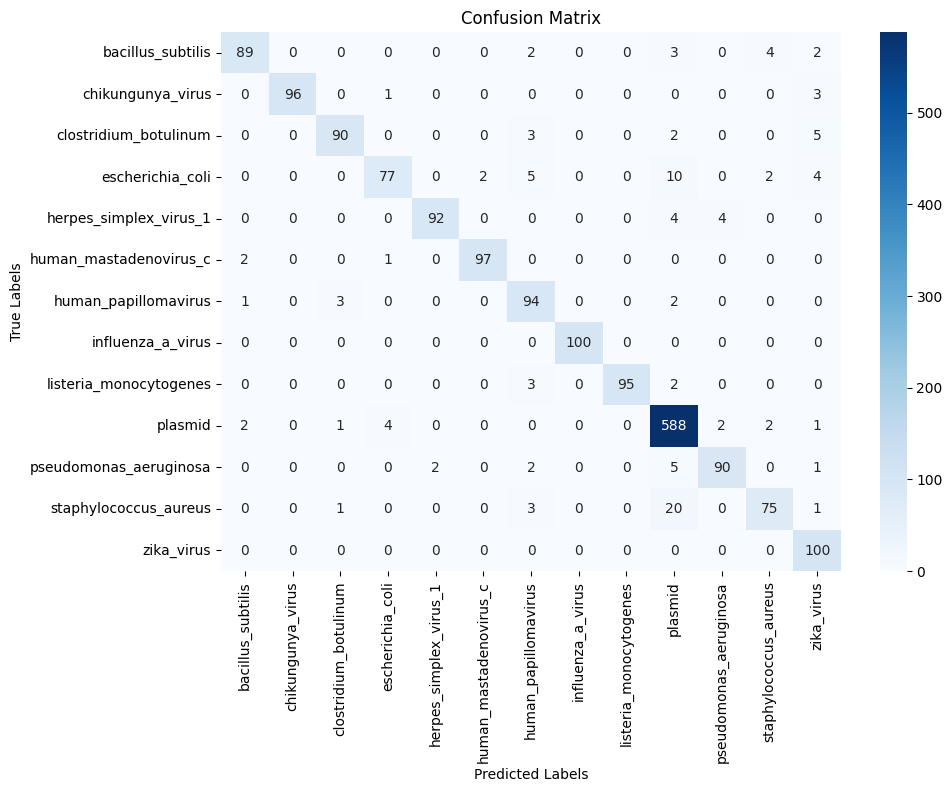

              precision    recall  f1-score   support

           0       0.95      0.89      0.92       100
           1       1.00      0.96      0.98       100
           2       0.95      0.90      0.92       100
           3       0.93      0.77      0.84       100
           4       0.98      0.92      0.95       100
           5       0.98      0.97      0.97       100
           6       0.84      0.94      0.89       100
           7       1.00      1.00      1.00       100
           8       1.00      0.95      0.97       100
           9       0.92      0.98      0.95       600
          10       0.94      0.90      0.92       100
          11       0.90      0.75      0.82       100
          12       0.85      1.00      0.92       100

    accuracy                           0.94      1800
   macro avg       0.94      0.92      0.93      1800
weighted avg       0.94      0.94      0.93      1800

AUC Score: 0.9507


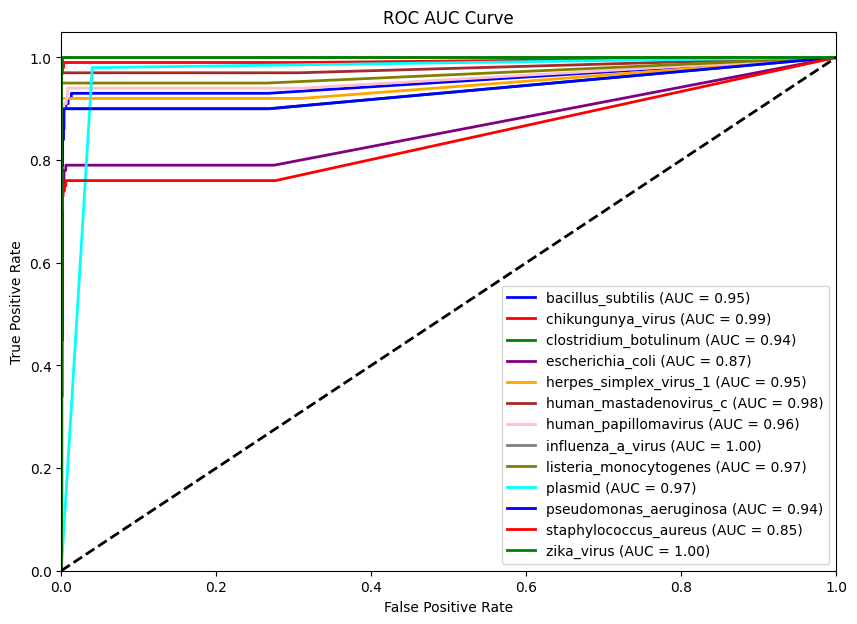

In [76]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

class ConditionalPipelineStep:
    def __init__(self, model1, model2, model3, validation_encoding, model_bacteria_encoding_reverse, model_virus_encoding_reverse):
        self.model1 = model1
        self.model2 = model2
        self.model3 = model3
        self.validation_encoding = validation_encoding
        self.model_bacteria_encoding_reverse = model_bacteria_encoding_reverse
        self.model_virus_encoding_reverse = model_virus_encoding_reverse
        
    def transform(self, X, Y):
        model1_preds = self.model1.predict(X)
        final_preds = []
        final_probs = np.zeros((X.shape[0], len(validation_encoding)))

        for i in range(X.shape[0]):
            target_label = validation_encoding_reverse[Y.iloc[i]]
            
            if model1_preds[i] == 0:
                if hasattr(self.model2, "predict_proba"):
                    temp_probs = self.model2.predict_proba([X[i]])[0]
                    for idx, prob in enumerate(temp_probs):
                        class_label = self.model_bacteria_encoding_reverse[idx]
                        final_probs[i, validation_encoding[class_label]] = prob
                temp = self.model2.predict([X[i]])
                predict_label = self.model_bacteria_encoding_reverse[temp[0]]

            elif model1_preds[i] == 2:
                if hasattr(self.model3, "predict_proba"):
                    temp_probs = self.model3.predict_proba([X[i]])[0]
                    for idx, prob in enumerate(temp_probs):
                        class_label = self.model_virus_encoding_reverse[idx]
                        final_probs[i, validation_encoding[class_label]] = prob
                temp = self.model3.predict([X[i]])
                predict_label = self.model_virus_encoding_reverse[temp[0]]

            else:
                predict_label = 'plasmid'
                final_probs[i, validation_encoding['plasmid']] = 1.0  
            
            final_preds.append(validation_encoding[predict_label])

        return np.array(final_preds), final_probs

pipeline = ConditionalPipelineStep(model_lvl1, model_bacteria, model_virus, 
                                   validation_encoding, model_bacteria_encoding_reverse, model_virus_encoding_reverse)

predictions, prediction_probs = pipeline.transform(x_scaled, target)

conf_matrix = confusion_matrix(target, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(validation_encoding.keys()), 
            yticklabels=list(validation_encoding.keys()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(target, predictions))

target_binarized = label_binarize(target, classes=list(validation_encoding.values()))
auc_score = roc_auc_score(target_binarized, prediction_probs, multi_class="ovr")
print(f"AUC Score: {auc_score:.4f}")

n_classes = len(validation_encoding)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(target_binarized[:, i], prediction_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 7))
colors = cycle(['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'{list(validation_encoding.keys())[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc='lower right')
plt.show()


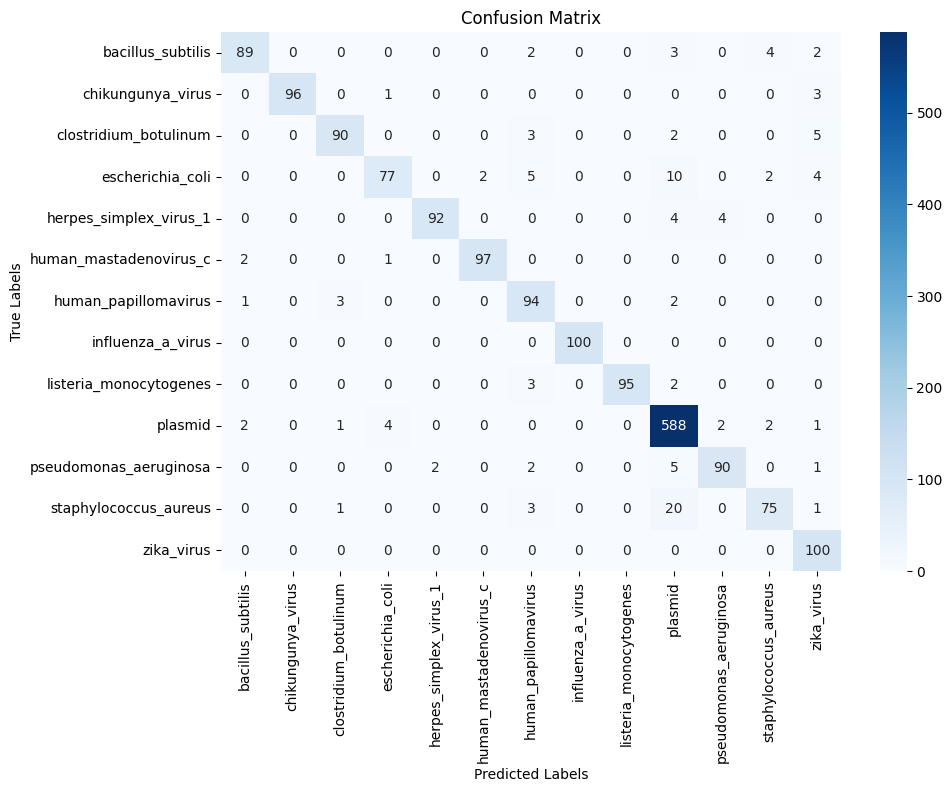

In [75]:
from sklearn.metrics import classification_report, confusion_matrix
conf_matrix = confusion_matrix(target, predictions)

# Plot the Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(validation_encoding.keys()), 
            yticklabels=list(validation_encoding.keys()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [69]:
print(len(predictions))

1800


In [70]:
from collections import Counter

predictions = predictions

counts = dict(Counter(predictions))
print(counts)

{1.0: 1683, 0.0: 117}


In [72]:
(counts[1]/1800)*100

93.5